In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
from os import mkdir
from os.path import isdir, join

import seaborn as sns
import itertools

chain = lambda vec, factor: list(itertools.chain.from_iterable([[x] * factor for x in vec]))

In [3]:
if not isdir('malt_fig'):
    mkdir('malt_fig')

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


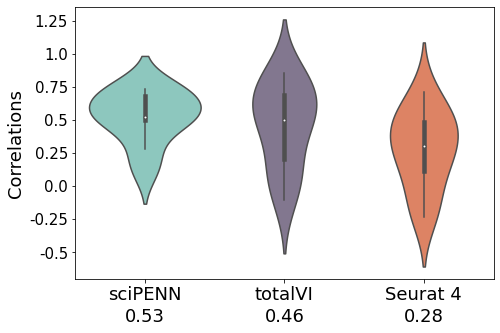

In [4]:
scipen_corrs = pd.read_csv('corrs_results/scipenn_malt.csv', index_col = 0)
totalvi_corrs = pd.read_csv('corrs_results/totalvi_malt.csv', index_col = 0)
seurat4_corrs = pd.read_csv('corrs_results/seurat4_malt.csv', index_col = 0)

scipen_corrs.columns = ['sciPENN']
totalvi_corrs.columns = ['totalVI']
seurat4_corrs.columns = ['Seurat 4']

data = pd.DataFrame(pd.concat((scipen_corrs, totalvi_corrs, seurat4_corrs), axis = 1))
q = len(scipen_corrs)

fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))
sns.violinplot(ax = ax, data = data, palette = ["#83D1C4","#817393","#F17950"])
mean_corrs = [float(x.mean()) for x in [scipen_corrs, totalvi_corrs, seurat4_corrs]]

ax.set_title(f"{mean_corrs[0]:.2f}", loc = 'left', x = 0.12, y = - 0.18, size = 18)
ax.set_title(f"{mean_corrs[1]:.2f}", y = - 0.18, size = 18)
ax.set_title(f"{mean_corrs[2]:.2f}", x = 0.88, y = - 0.18, loc = 'right', size = 18)

ax.set_ylabel('Correlations', size = 18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 18)
ax.set_yticklabels(ax.get_yticks(), fontsize = 15)
ax.figure.savefig('malt_fig/corrplot.pdf')

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


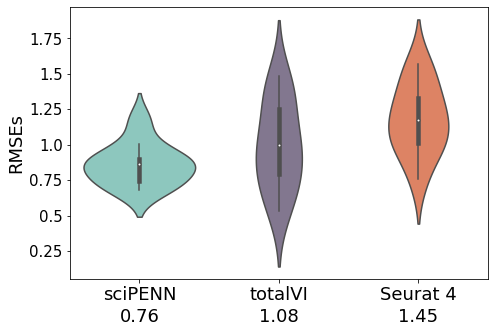

In [5]:
scipen_mses = pd.read_csv('mse_results/scipenn_malt.csv', index_col = 0)
totalvi_mses = pd.read_csv('mse_results/totalvi_malt.csv', index_col = 0)
seurat4_mses = pd.read_csv('mse_results/seurat4_malt.csv', index_col = 0)

scipen_mses.columns = ['sciPENN']
totalvi_mses.columns = ['totalVI']
seurat4_mses.columns = ['Seurat 4']

data = pd.DataFrame(pd.concat((scipen_mses**(1/2), totalvi_mses**(1/2), seurat4_mses**(1/2)), axis = 1), columns = ['sciPENN', 'totalVI', 'Seurat 4'])

fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))
sns.violinplot(ax = ax, data = data, palette = ["#83D1C4","#817393","#F17950"])
mean_mses = [float(x.mean()) for x in [scipen_mses, totalvi_mses, seurat4_mses]]

ax.set_title(f"{mean_mses[0]:.2f}", loc = 'left', x = 0.12, y = - 0.18, size = 18)
ax.set_title(f"{mean_mses[1]:.2f}", y = - 0.18, size = 18)
ax.set_title(f"{mean_mses[2]:.2f}", x = 0.88, y = - 0.18, loc = 'right', size = 18)

ax.set_ylabel('RMSEs', size = 18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 18)
ax.set_yticklabels(ax.get_yticks(), fontsize = 15)
ax.figure.savefig('malt_fig/mseplot.pdf')

In [6]:
scipenn_embedding = sc.read('scipenn_maltembedding.h5ad')

sc.pp.pca(scipenn_embedding, n_comps = 20)
sc.pp.neighbors(scipenn_embedding, n_pcs = 20)
sc.tl.umap(scipenn_embedding)

batch_map = {cell: 'PBMC' if name[:4] == 'DS-1' else 'Malt' for cell, name in zip(scipenn_embedding.obs.index, scipenn_embedding.obs['batch'])}

scipenn_embedding = pd.DataFrame(scipenn_embedding.obsm['X_umap'], index = scipenn_embedding.obs.index)
scipenn_embedding['Batch'] = [batch_map[cell] for cell in scipenn_embedding.index]
scipenn_embedding = scipenn_embedding.groupby('Batch')

In [7]:
totalvi_embedding = pd.read_csv('totalvi_maltembedding.csv', index_col = 0)
idx = totalvi_embedding.index
totalvi_embedding = AnnData(totalvi_embedding)
totalvi_embedding.obs.index = idx 

sc.pp.neighbors(totalvi_embedding, n_pcs = 0, use_rep = None)
sc.tl.umap(totalvi_embedding)

totalvi_embedding = pd.DataFrame(totalvi_embedding.obsm['X_umap'], index = totalvi_embedding.obs.index)
totalvi_embedding['Batch'] = [batch_map[cell] for cell in totalvi_embedding.index]
totalvi_embedding = totalvi_embedding.groupby('Batch')

In [8]:
seurat_trainumap = pd.read_csv("malt_trainumap.csv", index_col = 0)
seurat_testumap = pd.read_csv("malt_testumap.csv", index_col = 0)
seurat_testumap.columns = ["UMAP_1", "UMAP_2"]
seurat_umap = pd.concat((seurat_trainumap, seurat_testumap), axis = 0)

seurat_umap['Batch'] = [batch_map[cell] for cell in seurat_umap.index]
seurat_umap = seurat_umap.groupby('Batch')

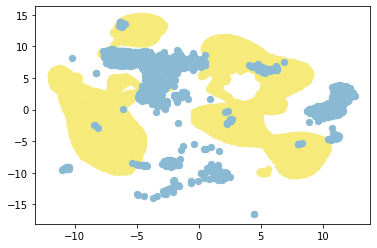

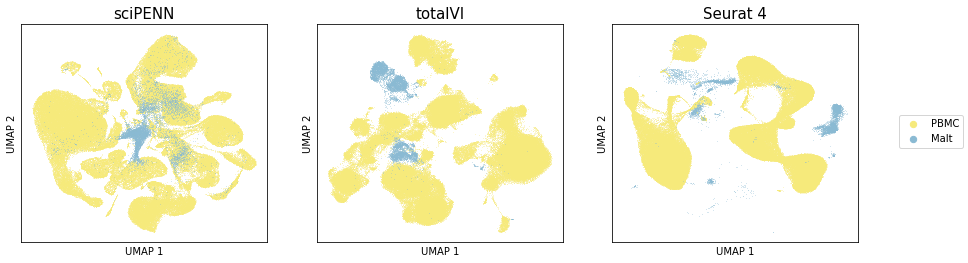

In [9]:
_, ax =  plt.subplots(1)
f, axs = plt.subplots(1, 3, figsize = (15, 4))

names = ['PBMC', 'Malt']
colormap = {'PBMC': '#F6EA7BFF', 'Malt': '#8ABAD3FF'}

def customize_axes(ax, name):
    ax.set_title(name, size = 15)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP 1', size = 10)
    ax.set_ylabel('UMAP 2', size = 10)
    
method_names = ['sciPENN', 'totalVI', 'Seurat 4']

[customize_axes(ax, name) for ax, name in zip(axs, method_names)]

for name in names:
    group = scipenn_embedding.get_group(name)
    axs[0].scatter(group[0], group[1], linewidth = 0, s = 1, marker = '.', label = name, c = colormap[name])
    
    group = totalvi_embedding.get_group(name)
    axs[1].scatter(group[0], group[1], linewidth = 0, s = 1, marker = '.', label = name, c = colormap[name])
    
    group = seurat_umap.get_group(name)
    axs[2].scatter(group['UMAP_1'], group['UMAP_2'], linewidths=0, s = 1, marker = '.', label = name, c = colormap[name])
    
    ax.scatter(group['UMAP_1'], group['UMAP_2'], label = name, c = colormap[name], s = 40)

Line, Label = ax.get_legend_handles_labels()
f.legend(Line, Label, loc = 'center right')
f.savefig('malt_fig/malt_embeddings.png', dpi = 300)

In [10]:
scipenn = sc.read("scipenn_maltfeatures.h5ad")
scipenn_features = AnnData(scipenn.layers['imputed'])
scipenn_features.var.index, scipenn_features.obs.index = scipenn.var.index, scipenn.obs.index

proteins = scipenn.var.index

truth = AnnData(scipenn.X)
truth.var.index, truth.obs.index = scipenn.var.index, scipenn.obs.index

In [11]:
totalvi_features = pd.read_csv("totalvi_maltfeatures.csv")
features, indices = totalvi_features.columns, totalvi_features.index
totalvi_features = AnnData(totalvi_features)
totalvi_features.var.index, totalvi_features.obs.index = features, indices

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
seurat4_features = pd.read_csv("seurat_maltfeatures.csv", index_col = 0).T
features, indices = seurat4_features.columns, seurat4_features.index
seurat4_features = AnnData(seurat4_features)
seurat4_features.var.index, seurat4_features.obs.index = features, indices

In [13]:
datasets = {'truth': truth, 'sciPENN': scipenn_features, 'totalVI': totalvi_features, 'Seurat 4': seurat4_features}
corrs = {'sciPENN': scipen_corrs, 'totalVI': totalvi_corrs, 'Seurat 4': seurat4_corrs}
mses = {'sciPENN': scipen_mses, 'totalVI': totalvi_mses, 'Seurat 4': seurat4_mses}

sc.pp.neighbors(truth, n_pcs = 0, use_rep = None)
sc.tl.umap(truth)
x, y = truth.obsm['X_umap'].T

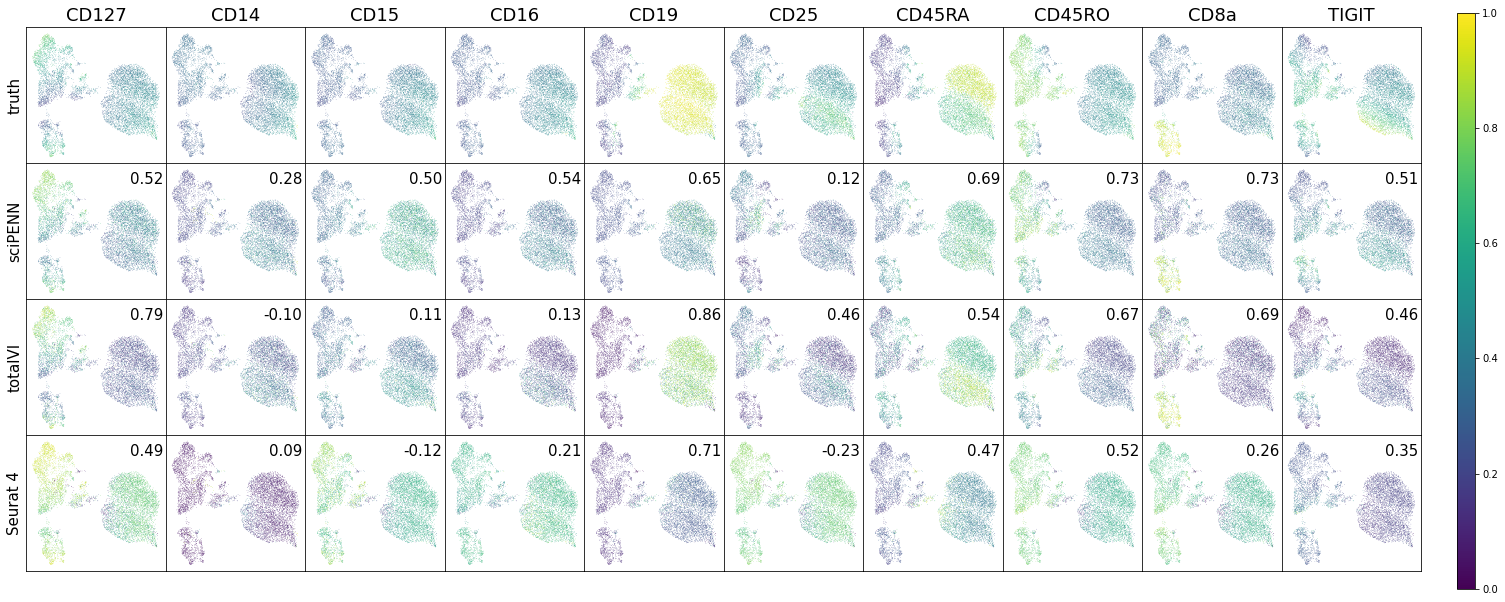

In [14]:
f, axs = plt.subplots(4, len(proteins), figsize = (25, 10))
idx = -1

for name in datasets:
    dataset = datasets[name]
    
    idx += 1
    for i, prot in enumerate(proteins):
        expr = dataset[:, prot].X[:, 0]
        expr = (expr - np.min(expr))/(np.max(expr) - np.min(expr))
        
        
        axs[idx, i].scatter(x, y, c = expr, marker='.', s=1, linewidths=0, cmap = 'viridis')
        axs[idx, i].set_xticks([])
        axs[idx, i].set_yticks([])
        
        if not idx:
            axs[idx, i].set_title(prot, size = 18)
        else:
            axs[idx, i].set_title(f"{corrs[name].loc[prot].mean():.2f}", loc = 'right', x = 0.98, y = 0.8, size = 15)

        if not i:
            axs[idx, i].set_ylabel(name, size = 15)
            
PCM = axs[idx, i].get_children()[0]

cb_ax = f.add_axes([0.92, 0.1, 0.01, 0.8])
cbar = f.colorbar(PCM, cax=cb_ax)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.)

f.savefig('malt_fig/malt_fplots.png', dpi = 300)

In [15]:
base_path = 'totalVI_quantiles_malt'

q10 = pd.read_csv(join(base_path, 'q10.csv'), index_col = 0)
q25 = pd.read_csv(join(base_path, 'q25.csv'), index_col = 0)
q75 = pd.read_csv(join(base_path, 'q75.csv'), index_col = 0)
q90 = pd.read_csv(join(base_path, 'q90.csv'), index_col = 0)

truth = pd.read_csv(join(base_path, 'truth.csv'), index_col = 0)

In [16]:
totalVI_coverage50 = (q75.to_numpy() > truth.to_numpy())*(q25.to_numpy() < truth.to_numpy())
totalVI_coverage50 = totalVI_coverage50.mean(axis = 0)

In [17]:
scipenn = sc.read("scipenn_maltfeatures.h5ad")

scipenn_coverage50 = (scipenn.layers['q75'] > truth.to_numpy()) * (scipenn.layers['q25'] < truth.to_numpy())
scipenn_coverage50 = scipenn_coverage50.mean(axis = 0)

In [18]:
totalVI_coverage80 = (q90.to_numpy() > truth.to_numpy())*(q10.to_numpy() < truth.to_numpy())
totalVI_coverage80 = totalVI_coverage80.mean(axis = 0)

In [19]:
scipenn_coverage80 = (scipenn.layers['q90'] > truth.to_numpy()) * (scipenn.layers['q10'] < truth.to_numpy())
scipenn_coverage80 = scipenn_coverage80.mean(axis = 0)

In [20]:
data = np.concatenate((totalVI_coverage50, scipenn_coverage50, totalVI_coverage80, scipenn_coverage80))

In [21]:
method = (['totalVI'] * len(totalVI_coverage50) + ['sciPENN'] * len(scipenn_coverage50)) * 2
quantile = ['50% PI'] * (len(totalVI_coverage50) + len(scipenn_coverage50)) + ['80% PI'] * (len(totalVI_coverage50) + len(scipenn_coverage50))

In [22]:
data = {'Coverage': data, 'Method': method, 'Interval': quantile}
df = pd.DataFrame(data)

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


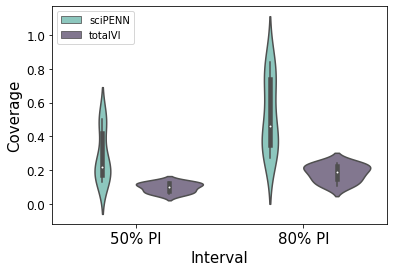

In [23]:
fig, ax = plt.subplots(1, 1)
sns.violinplot(ax = ax, x = "Interval", y = "Coverage", hue = "Method", hue_order = ['sciPENN', 'totalVI'], data = df, palette = ["#83D1C4","#817393"])
Line, Label = ax.get_legend_handles_labels()
ax.legend(Line, Label, loc = 'upper left')
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15)
ax.set_yticklabels([round(x, 1) for x in ax.get_yticks()], fontsize = 12)
ax.set_xlabel(ax.get_xlabel(), size = 15)
ax.set_ylabel(ax.get_ylabel(), size = 15)

fig.savefig('malt_fig/coverageprob.pdf')